# Introduction to Artificial Neural Networks

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["legend.fontsize"] = "x-large"
plt.rcParams["axes.labelsize"] = "x-large"

## (x, y) points dataset

Given a dataset $\{\mathbf{x}_i, y_i\}_{i=1}^{N}$, our goal is to estimate $y$ from $\mathbf{x}$. Fancy way of saying we have a bunch of (x, y) points and want to predict y.

To keep things simple, we will use a dataset with 1-dimensional $x$ and $y$ (scalar values).

We generate the data by defining a "true" function, $g(x)$, and then sampling from the function with noise: $y_i = g(x_i) + \epsilon_i$. We can control the shape of the function $g$ by varying the **smoothness (> 0)** and the amount of error in $y_i$ by varying the **signal_to_noise (> 0)**. Try changing these values and see how the resulting data and models are affected.

The function below is used to generate an example dataset with the parameters described above. The same dataset will be generated each time you call ```generate_data()```, unless you change the `seed` argument.

In [4]:
from scipy.spatial.distance import pdist, squareform

# number of data samples
num_samples = 1000

def generate_data(smoothness=0.15, signal_to_noise=5.0, num_samples=1000, seed=1):
    """
    Generate a synthetic dataset of (x, y) values whose y-values approximate a function.
    
    Args:
      smoothness (float): controls shape of basis function (default = 0.15)
      signal_to_noise (float): signal-to-noise ratio for noisy training data (default = 5.0)
      num_samples (int): number of samples to generate data for (default = 1000)
      seed (int): value passed to `np.random.seed()` at the beginning of this function (default = 1)
    
    Returns:
      x (np.ndarray[float]): 1d array of shape (`num_samples`,) with x values
      y (np.ndarray[float]): 2d array of shape (`num_samples`, 1) with noisy training y-values
      y_true (np.ndarray[float]): 2d array of shape (`num_samples`, 1) with true y-values
    """
    np.random.seed(seed)
    
    # define data samples on regular grid
    x = np.linspace(0, 1, num_samples)

    # Gaussian basis
    basis = np.exp(-squareform(pdist(x[:, np.newaxis], 'sqeuclidean')) / (smoothness ** 2))

    # random sparse weights
    num_nonzero = np.ceil(num_samples * smoothness)
    weights = (np.random.random((num_samples, 1)) - 0.5) * 100.0 / num_nonzero
    weights[np.random.random(num_samples) < (1 - smoothness)] = 0.0

    # define true function
    y_true = basis @ weights

    # generate data from true function plus noise
    noise_scale = np.std(y_true) / signal_to_noise
    y = y_true + noise_scale * np.random.standard_normal((num_samples, 1))
    
    return x, y, y_true

Now we'll generate a dataset and plot the data and true function:

In [ ]:
x, y, y_true = generate_data()

print(f"x.shape = {x.shape}")
print(f"y.shape = {y.shape}")
print(f"y_true.shape = {y_true.shape}")

In [ ]:
print(x[:5])
print(y[:5].reshape(5,))

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(x, y, 'ko', alpha=0.3, markersize=2, label='generated data')
plt.plot(x, y_true, 'b-', label='true function')
plt.xlabel("x", fontsize="x-large")
plt.ylabel("y", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.show()

## Simple neural network

We will start by creating the **World's Simplest Neural Network(TM)**: a 1-layer network with a single node:

<img src="assets/linear-regression-node.png" width="250">

A basic neural network node computes a weighted sum of the inputs (for the first layer, the inputs are simply the elements of $\mathbf{x}_i$) to produce a single output $z_i$:

$$z_i = f(\mathbf{x}_i, \mathbf{w}) = w_0 + w_1 x_{i1} + w_2 x_{i2} + \ldots + w_p x_{ip},$$

where the bias $w_0$ is optional, and the weights $\mathbf{w}$ are learned to get the best output $z_i$. 

We can define "best output" in different ways depending on the loss function chosen to quantify how close the output $z_i$ is to the true value $y_i$. A standard loss function is the sum of squared errors:

$$\sum_{i}{\left(z_i - y_i\right)^2}.$$

**Takeaway: Single node = <u>????????</u>**

The above neural network model (single node with sum of squared error loss) is identical to [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) linear regression. If we added [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) terms to the loss function, the model would be identical to other standard [linear regression](https://en.wikipedia.org/wiki/Linear_regression) models like ridge regression and lasso.

### Linear regression

For our regression dataset, we only have a single input element (scalar $x_i$), so our single-node linear regression model is simply: $z_i = w_0 + w_1 x_{i1}$.

This model can be created in Keras as follows:

In [ ]:
from tensorflow import set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

set_random_seed(1)

# LIVE CODE 1


From the model summary, we can see that we have a single (Dense) layer, where the second element of the output shape tells us the number of nodes (the first element corresponds to unknown number of $x_i$ samples in a batch). We can also infer that we have a single input from the number of parameters (bias plus one weight).

Let's train the model for 100 epochs, evaluate the final error on the training data, and plot the loss during training.

* **epoch**: in machine learning, an epoch is passing all training samples to model for fitting / learning

In [ ]:
history = model.fit(x, y, epochs=100, verbose=0)

metrics = model.evaluate(x, y, verbose=0)
print(f'Mean Squared Error = {metrics}')

plt.figure(figsize=(4, 3))
plt.plot(history.epoch, np.array(history.history['loss']))
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.grid()
plt.tight_layout()

Now let's plot the model predictions ($z_i$) with the data:

In [ ]:
z = model.predict(x)

plt.figure(figsize=(12, 6))
plt.plot(x, y, 'ko', alpha=0.3, markersize=2, label='data')
plt.plot(x, y_true, 'b-', label='true function')
plt.plot(x, z, 'r-', linewidth=2, label='prediction')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

It's no surprise that a linear model doesn't fit the data very well. So what happens if we add another layer that has two nodes?

<img src="assets/2-layer-model.png" width="600">


In [ ]:
# LIVE CODE 2


In [ ]:
history2 = model2.fit(x, y, epochs=100, verbose=0)

metrics = model2.evaluate(x, y, verbose=0)
print(f'Mean Squared Error = {metrics}')

z2 = model2.predict(x)

plt.figure(figsize=(12, 6))
plt.plot(x, y, 'ko', alpha=0.3, markersize=2, label='data')
plt.plot(x, y_true, 'b-', label='true function')
plt.plot(x, z2, 'r-', linewidth=2, label='predictions')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.show()

The two-layer, multiple-node model is identical to the single-node model!

#### _Any number of nodes and layers = linear regression_

We can do the math to confirm this.

First layer with 2 nodes:

$\begin{align}
    z^{(1)} &= w_0^{(1)} + w_1^{(1)}x \\
    z^{(2)} &= w_0^{(2)} + w_1^{(2)}x
\end{align}$

Second layer with 1 node:

$\begin{align}
    z &= w_0 + w_1 z^{(1)} + w_2 z^{(2)} \\
    z &= w_0 + w_1\left(w_0^{(1)} + w_1^{(1)}x\right) + w_2\left(w_0^{(2)} + w_1^{(2)}x\right) \\
    z &= \left(w_0 + w_1 w_0^{(1)} + w_2 w_0^{(2)}\right) + \left(w_1 w_1^{(1)} + w_2 w_1^{(2)}\right)x \\
    z &= \hat{w}_0 + \hat{w}_1 x
\end{align}$

Ultimately, we get the same linear model ($z = \hat{w}_0 + \hat{w}_1 x$) regardless of the number of nodes or layers in the network.

### Nonlinear regression

Clearly we need to make the model nonlinear to fit our data, so what's the missing ingredient?

<u>???????????</u>

#### Nonlinear activation functions

An [activation function](https://en.wikipedia.org/wiki/Activation_function) maps a node output $z$ to a value that indicates whether or not the node should be "activated" and pass its information to the next layer in the network (the biological inspiration is the "firing" of a neuron). 

Three well-known nonlinear mappings, $\phi(z)$, are: 

1. sigmoid
2. tanh (hyperbolic tangent)
3. ReLU (rectified linear unit)

These activation functions are plotted below.

In [ ]:
z = np.linspace(-5, 5, 100)
sigmoid = 1.0/(1.0 + np.exp(-z))
tanh = np.tanh(z)
relu = z.copy()
relu[relu < 0] = 0.0

plt.figure(figsize=(12, 4))
plt.subplot(131); plt.plot(z, sigmoid); plt.grid(); plt.xlabel('z'); plt.ylabel('$\phi$(z)'); plt.title('sigmoid')
plt.subplot(132); plt.plot(z, tanh); plt.grid(); plt.xlabel('z'); plt.title('tanh')
plt.subplot(133); plt.plot(z, relu); plt.grid(); plt.xlabel('z'); plt.title('relu')
plt.tight_layout()

The Python functions below will be used to define and train the models with different activation functions.

In [91]:
from tensorflow.keras.initializers import Constant

# custom bias initialization function
def linear_spacing(shape, dtype=None, partition_info=None):
    return np.linspace(-0.8, 0.2, shape[0])

# define two-layer regression model
def define_model(activation: str, num_layer1_units: int):
    model = Sequential()
    
    # layer 1 / 2
    if activation == 'relu':
        model.add(Dense(num_layer1_units, input_dim=1, activation=activation, kernel_initializer='ones', bias_initializer=linear_spacing, name="layer_1"))
    else:
        model.add(Dense(num_layer1_units, input_dim=1, activation=activation, bias_initializer=Constant(value=-np.mean(x)), name="layer_1"))
    
    # layer 2 / 2
    model.add(Dense(1, name="layer_2"))
    
    model.compile(loss='mean_squared_error', optimizer='sgd')
    return model

# training function for more user-friendly progress tracking
def fit_model(x, y, activation, num_layer1_units, epochs):
    model = define_model(activation, num_layer1_units)
    
    loss = []
    for epoch in tqdm(range(epochs), desc=activation):
        history = model.fit(x, y, epochs=1, verbose=0)
        loss.extend(history.history['loss'])
    
    metrics = model.evaluate(x, y, verbose=0)
    print(f'Mean Squared Error = {metrics}')
    
    return model, loss

Now let's train a two-layer model with 4 nodes in the first layer (with different activation functions) and 1 node in the second (output) layer.

In [104]:
# NOTE: This cell will take a few minutes to run on a CPU!

activations = ('relu', 'tanh', 'sigmoid')
num_layer1_units = 4
epochs = 5000

models = dict()
for activation in activations:
    model, loss = fit_model(x, y, activation, num_layer1_units, epochs)
    models[activation] = {'model': model, 'epochs': epochs, 'loss': loss}

A Jupyter Widget

Mean Squared Error = 0.06306945699453353


A Jupyter Widget

Mean Squared Error = 0.07065670749545097


A Jupyter Widget

Mean Squared Error = 0.08298243397474289


Let's look at convergence of the three models:

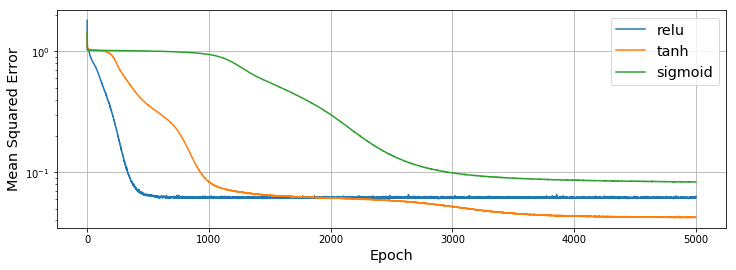

In [107]:
plt.figure(figsize=(12, 4))
for activation, model in models.items():
    plt.plot(range(model['epochs']), np.array(model['loss']), label=activation)
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('Mean Squared Error'); plt.grid(); plt.legend(); plt.show()

* ReLU has converged after ~1000 epochs
* tanh is near convergence after 5000 epochs (or ~2200 epochs for the same error as ReLU)
* sigmoid is much slower to learn than tanh (even though they have the same functional form) but would eventually reach the same error

There are a few interesting aspects to the different learned models. Let's start by looking at the model predictions using the tanh and sigmoid activation functions:

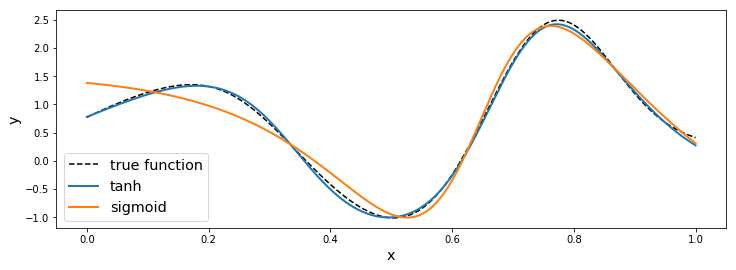

In [109]:
plt.figure(figsize=(12, 4))
plt.plot(x, y_true, 'k--', label='true function')

for activation, model in models.items():
    if activation == 'relu': continue
    y_hat = model['model'].predict(x)
    plt.plot(x, y_hat, linewidth=2, label=activation)

plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

The tanh (and eventually sigmoid) activation function can be used to accurately represent the true function with just 1 hidden layer of 4 nodes. Let's look at what those nodes are actually doing.

Now let's look at the model predictions using the ReLU activation function:

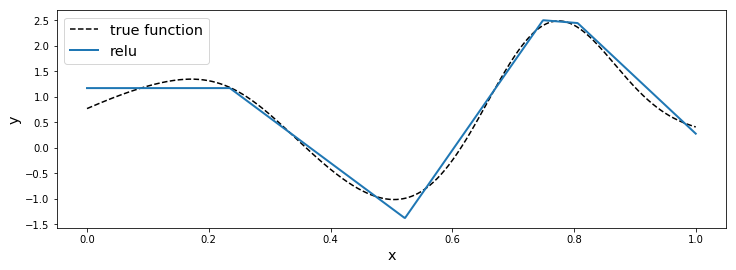

In [111]:
activation = 'relu'

y_hat = models[activation]['model'].predict(x)

plt.figure(figsize=(12, 4))
plt.plot(x, y_true, 'k--', label='true function')
plt.plot(x, y_hat, linewidth=2, label=activation)
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

Notice that the predicted function is not smooth like tanh and sigmoid. In fact, the ReLU activation function results in a **piecewise linear** functional approximation. Since our dataset happens to have a smooth generating function, ReLU is not able to approximate the function as accurately as tanh or sigmoid with only 4 hidden nodes.

Let's see what happens when we train a larger network that uses ReLU activations:

In [ ]:
# this cell will take a couple of minutes to run on a CPU!
big_relu_model, loss = fit_model(x, y, "relu", 12, 5000)
models["relu (big)"] = {'model': big_relu_model, 'epochs': epochs, 'loss': loss}

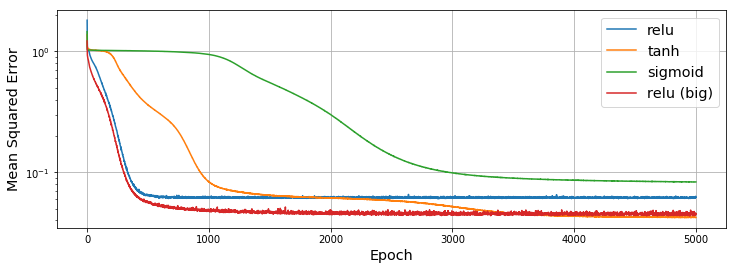

In [121]:
plt.figure(figsize=(12, 4))
for activation, model in models.items():
    plt.plot(range(model['epochs']), np.array(model['loss']), label=activation)
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('Mean Squared Error'); plt.grid(); plt.legend(); plt.show()

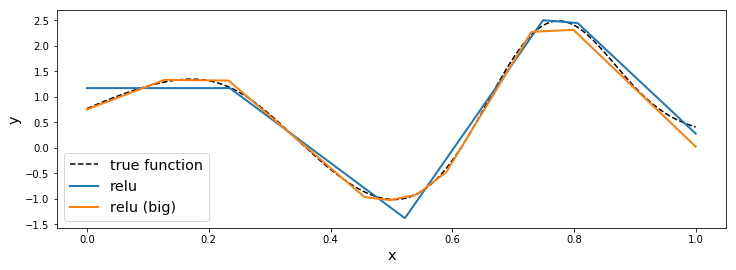

In [126]:
plt.figure(figsize=(12, 4))
plt.plot(x, y_true, 'k--', label='true function')

for activation in ('relu', 'relu (big)'):
    y_hat = models[activation]['model'].predict(x)    
    plt.plot(x, y_hat, linewidth=2, label=activation)

plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

### Logistic regression

Once linear regression is understood, extending the model to [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) for classification is trivial. For binary classification, we'll define the dataset as $\{\mathbf{x}_i, y_i\}_{i=1}^{N}$, except now $y_i$ can only be one of two possible values: $y_i \in \{0, 1\}$.

Let's take the same generated dataset that we used for regression and simply make large values more likely to have a value of $y_i=1$ and small values more likely to have a value of $y_i=0$. This should sound familiar, since it's exactly what the sigmoid function does (it maps independent values to dependent values in [0, 1]).

We can control the degree of separability between the two classes by varying the **discriminability (> 0)**. Try changing this value to see how the resulting data and models are affected.

In [9]:
discriminability = 2.0

In [ ]:
x, y, y_true = generate_data()

sigmoid = lambda z: 1.0 / (1.0 + np.exp(-z))
y_class_true = sigmoid(discriminability * y_true)
y_class = np.random.binomial(1, y_class_true)

plt.figure(figsize=(12, 4))
plt.plot(x, y_class, 'k.', markersize=2, label='data')
plt.plot(x, y_class_true, 'b-', label='true probability of class y=1')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Returning to our single-node linear regression model, $z_i = w_0 + w_1 x_{i1}$, the only change we need to make is to apply the sigmoid (logistic) function, $\sigma$, to the output: $\hat{y}_i = \sigma(z_i)$.

We could use the same loss function (sum of squared errors) for this model, however it turns out that a much better choice is the [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression) loss function:

$$-\frac{1}{N}\sum_{i}{y_i\log{\hat{y}_i} + (1 - y_i)\log{(1 - \hat{y}_i)}}.$$

This model can be created in Keras as follows:

In [ ]:
from tensorflow import set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# LIVE CODE 3


Let's train the model and print the accuracy. The accuracy is the fraction of correctly classified samples, where a predicted classification is $1$ when $\hat{y}_i > 0.5$ and $0$ otherwise.

In [ ]:
# this takes about 30s to run on CPU
history = model.fit(x, y_class, epochs=500, verbose=0)

print(f"Accuracy = {history.history['acc'][-1]}")

In [ ]:
y_hat = model.predict(x)

plt.figure(figsize=(12, 4))
plt.plot(x, y_class, 'k.', markersize=2, label='data')
plt.plot(x, y_class_true, 'b-', label='true probability of class y=1')
plt.plot(x, y_hat, 'r-', linewidth=2, label='predicted probability of class y=1')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="best", fontsize="large")
plt.show()

No surprise, a _linear_ classification model doesn't fit the data. The model can't do much better than approximating the mean of all class labels.

Just to demonstrate how the predicted probabilities are generated by our model, we can extract the model's parameters and reproduce some results manually:

In [ ]:
# our model has just a single layer
model.layers

In [ ]:
layer = model.layers[0]
layer.weights

In [ ]:
layer.get_weights()

In [ ]:
kernel, bias = layer.get_weights()
kernel = kernel[0][0]
bias = bias[0]

In [ ]:
for x_val in np.arange(0, 1.01, 0.05):
    print(f"model(x = {x_val:0.2f}) -> {sigmoid(kernel * x_val + bias):0.3f}")

### Nonlinear classification

Let's use the same two-layer nonlinear model as we did earlier (with tanh activations on the first layer), but modified for classification (what needs to change?):

In [134]:
from tensorflow import set_random_seed
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

activation = 'tanh'
units = 4

# LIVE CODE 4


In [135]:
# NOTE: This cell will take a few minutes to run on CPU!

# train the model
loss = []
epochs = 5000
for epoch in tqdm(range(epochs), desc=activation):
    history = model.fit(x, y_class, epochs=1, verbose=0)
    loss.extend(history.history['loss'])

A Jupyter Widget

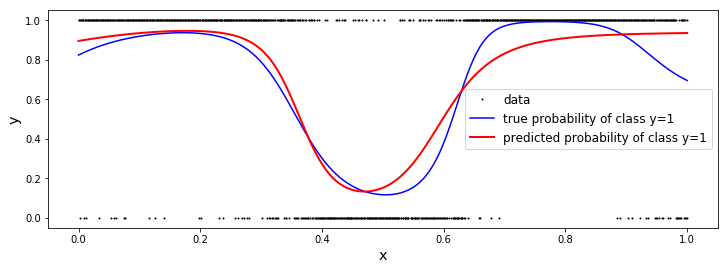

In [136]:
plt.figure(figsize=(12, 4))
plt.plot(x, y_class, 'k.', markersize=2, label='data')
plt.plot(x, y_class_true, 'b-', label='true probability of class y=1')

y_hat = model.predict(x)
plt.plot(x, y_hat, 'r-', linewidth=2, label='predicted probability of class y=1')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize="large")
plt.show()

In [137]:
print(f"Accuracy = {history.history['acc'][-1]}")

Accuracy = 0.851
